In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pickle
saving_name = './persDistances.pkl'

import gudhi as gd
import gudhi.hera as hera
from gudhi.wasserstein import wasserstein_distance # no bottleneck because the implemented one doesn't have the correct internal p!
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float64)
inf = float('inf')

In [91]:
def test_model(model, test_data, H = 1, if_plot = True):
    # Set the model to evaluation mode
    model.eval()

    target_labs = np.array([])
    pred_labs = np.array([])
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        for h0, h1, cl in test_data:

            # Forward pass
            if H==0:
                outputs = model(torch.tensor(h0), inf)
            else:
                outputs = model(torch.tensor(h1), inf)
                
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += cl.size(0)
            # Total correct predictions
            correct += (predicted == cl).sum().item()
            target_labs = np.append(target_labs, cl)
            pred_labs = np.append(pred_labs, predicted)

    # Calculate accuracy
    accuracy = 100 * correct / total
    # print('Accuracy on the test set: {:.2f}%'.format(accuracy))

    if if_plot:
        cm = confusion_matrix(np.array(target_labs), np.array(pred_labs))
        classes = [1,2,3,4,5]
        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
        
    return accuracy

In [3]:
# load everything

file_name = './persDistances.pkl'

with open(file_name, 'rb') as file:
    loaded_data = pickle.load(file)

print(f"Data has been loaded from {file_name}")
print(loaded_data.keys())
train_size = loaded_data['original_train_data'].shape[0]
test_size = loaded_data['original_test_data'].shape[0]
preproc_size = loaded_data['test_H0_preproc'].shape[-1]

Data has been loaded from ./persDistances.pkl
dict_keys(['H0_dist_pers', 'H1_dist_pers', 'p', 'original_train_data', 'train_lab', 'train_H0_preproc', 'train_H1_preproc', 'original_test_data', 'test_lab', 'test_H0_preproc', 'test_H1_preproc', 'model_params', 'model_str'])


In [5]:
loaded_data['model_params']

OrderedDict([('layer1_H.params',
              tensor([[ 1.1749e+01,  3.1117e+00, -6.0686e-01,  ...,  1.3241e-02,
                        8.5991e-03,  8.3066e-03],
                      [ 5.2570e+00, -7.6866e-01,  8.3880e+00,  ...,  9.0773e-03,
                        9.3250e-03,  6.3341e-03],
                      [ 9.6003e+00,  6.1606e+00,  3.6952e+00,  ...,  1.0323e-02,
                        5.0075e-03,  1.0325e-02],
                      ...,
                      [ 7.0209e+00,  7.2824e-01,  8.4339e-01,  ...,  8.1132e-03,
                        1.2101e-02,  6.6165e-03],
                      [ 9.6382e+00,  6.8383e+00,  2.3242e+00,  ...,  9.9154e-03,
                        8.3429e-03,  5.5277e-03],
                      [ 1.3566e+01,  3.6038e+00,  1.9793e+00,  ...,  6.1671e-03,
                        6.8211e-03,  5.4055e-03]])),
             ('layer2_H.params',
              tensor([[-0.2086, -0.6979, -0.0997,  ...,  3.8186, -1.1505, -0.5320],
                      [ 0.5734,  0

In [94]:
stableranks_dict = {
    'train_H0': [],
    'train_H1': [],
    'test_H0': [],
    'test_H1': []
}
stableranks_dict['train_H0'] = loaded_data['train_H0_preproc']
stableranks_dict['train_H1'] = loaded_data['train_H1_preproc']
stableranks_dict['test_H0'] = loaded_data['test_H0_preproc']
stableranks_dict['test_H1'] = loaded_data['test_H1_preproc']

for key, dat in zip(stableranks_dict.keys(), \
                    [stableranks_dict['train_H0'], stableranks_dict['train_H1'], stableranks_dict['test_H0'], stableranks_dict['test_H1']]):
    stableranks_dict[key] = np.array([dat[i,1,:] - dat[i,0,:] for i in range(dat.shape[0])])

# check about means and std between train and test
mean_train_H0 = np.mean(stableranks_dict['train_H0'], axis=0)
std_train_H0 = np.std(stableranks_dict['train_H0'], axis=0)
mean_train_H1 = np.mean(stableranks_dict['train_H1'], axis=0)
std_train_H1 = np.std(stableranks_dict['train_H1'], axis=0)

mean_test_H0 = np.mean(stableranks_dict['test_H0'], axis=0)
std_test_H0 = np.std(stableranks_dict['test_H0'], axis=0)
mean_test_H1 = np.mean(stableranks_dict['test_H1'], axis=0)
std_test_H1 = np.std(stableranks_dict['test_H1'], axis=0)

# H0
print(f'{mean_train_H0.mean() = } - {mean_test_H0.mean() = }')
print(f'{std_train_H0.mean() = } - {std_test_H0.mean() = }')
# H1
print(f'{mean_train_H1.mean() = } - {mean_test_H1.mean() = }')
print(f'{std_train_H1.mean() = } - {std_test_H1.mean() = }')

# # test_size = loaded_data['original_test_data'].shape[0]
# # DISTANCES
# H0_SR_distances = np.zeros((test_size, test_size))
# H1_SR_distances = np.zeros((test_size, test_size))

# # for i in range(test_size):
# for i in tqdm(range(test_size),desc = f'L_\infty DISTANCES among STABLE RANKS'): # 2 mins each one....
#     sr_H0_i = stableranks_dict['test_H0'][i,:].transpose()
#     sr_H1_i = stableranks_dict['test_H1'][i,:].transpose()
#     # for j in tqdm(range(test_size)):
#     for j in range(test_size):
#         sr_H0_j = stableranks_dict['test_H0'][j,:].transpose()
#         sr_H1_j = stableranks_dict['test_H1'][j,:].transpose()
#         # L_infty distance!
#         H0_SR_distances[i,j] = np.max(np.abs(sr_H0_i - sr_H0_j))
#         H1_SR_distances[i,j] = np.max(np.abs(sr_H1_i - sr_H1_j))

mean_train_H0.mean() = 0.18645113427113832 - mean_test_H0.mean() = 0.18325928093318122
std_train_H0.mean() = 0.041041970667470444 - std_test_H0.mean() = 0.040542467341495074
mean_train_H1.mean() = 0.17774672218819268 - mean_test_H1.mean() = 0.1734691321114526
std_train_H1.mean() = 0.04525501474799577 - std_test_H1.mean() = 0.04994134800754962


In [95]:
# batched_data
# stableranks_dict['train_H0'], ..., train_lab, test_lab
batch_size = 128

# # shuffling data
# combined = list(zip(stableranks_dict['train_H0'], stableranks_dict['train_H1'], loaded_data['train_lab']))

# # Shuffle the combined list
# np.random.shuffle(combined)

# # Unpack the shuffled list back into separate tensors
# data1_shuffled, data2_shuffled, labels_shuffled = zip(*combined)

# # Convert them back to PyTorch tensors
# data1_shuffled = torch.tensor(data1_shuffled)
# data2_shuffled = torch.tensor(data2_shuffled)
# labels_shuffled = torch.tensor(labels_shuffled)

# L = stableranks_dict['train_H0'].shape[0]
# n_batches = L//batch_size +1
# batched_train = []
# for i in range(n_batches):
#     batched_train.append([data1_shuffled[i*batch_size:(i+1)*batch_size,:],\
#                             data2_shuffled[i*batch_size:(i+1)*batch_size,:],\
#                             labels_shuffled[i*batch_size:(i+1)*batch_size]])

# don't want to shuffle things now!
L = stableranks_dict['train_H0'].shape[0]
n_batches = L//batch_size +1
batched_train = []
for i in range(n_batches):
    batched_train.append([torch.tensor(stableranks_dict['train_H0'][i*batch_size:(i+1)*batch_size,:]),\
                        torch.tensor(stableranks_dict['train_H1'][i*batch_size:(i+1)*batch_size,:]),\
                        torch.tensor(loaded_data['train_lab'][i*batch_size:(i+1)*batch_size])])
test_ds = [[torch.tensor(stableranks_dict['test_H0']),\
            torch.tensor(stableranks_dict['test_H1']),\
            torch.tensor(loaded_data['test_lab'])]]

> NN

In [6]:
class linfLayer(nn.Module):
    def __init__(self, in_blocks, out_blocks, scaling = []):
        super().__init__()
        
        if len(scaling)==2:
            params = torch.randn((out_blocks, in_blocks)) * scaling[1] + scaling[0] # random*std + mean
            self.params = torch.nn.Parameter(data=params)
        elif len(scaling)==1:
            params = torch.randn((out_blocks, in_blocks)) * scaling[0] # random*std
            self.params = torch.nn.Parameter(data=params)
        else:
            params = torch.randn((out_blocks, in_blocks)) # only random in gaussian(mean=0, std=1)
            self.params = torch.nn.Parameter(data=params)
            
    def forward(self, x, p):
        res = torch.cdist(x, self.params, p=p) #torch.cdist but with custom params
        return res
    
class linfModel(nn.Module):
    def __init__(self, sizes, scale):
        super().__init__()
        layers = [linfLayer(in_blocks=sizes[0], out_blocks=sizes[1], scaling=scale)]
        
        
        # Add hidden layers
        for i in range(2, len(sizes)):
            layers.append(linfLayer(in_blocks=sizes[i-1], out_blocks=sizes[i]))
        
        # Use ModuleList to hold the layers
        self.layers = nn.ModuleList(layers)


    def forward(self, x, p):
        # Forward pass through all the layers
        for layer in self.layers[:-1]:
            x = layer(x, p)
            x = x - x.mean(axis=0)
        out = self.layers[-1](x, p)
        return -out

In [7]:
# save_folder = f'./LinfModels/'
model_str = loaded_data['model_str']
# model_str = save_folder + 'H1_400_acc_84.000.pth'
saved_params = torch.load(model_str)

sizes = [preproc_size]
for i, k in enumerate(saved_params.keys()):
    sizes.append(saved_params[k].shape[0])
    print(f'Layer {i+1} Size = [{saved_params[k].shape}')
# model_H0 = linfModel(preproc_size, scale=[mean_train_H0, std_train_H0])
model = linfModel(sizes, scale=[mean_train_H1, std_train_H1])

model.load_state_dict(saved_params)

Layer 1 Size = [torch.Size([1000, 600])
Layer 2 Size = [torch.Size([300, 1000])
Layer 3 Size = [torch.Size([5, 300])


NameError: name 'mean_train_H1' is not defined

In [82]:
# output from train
train_output = torch.tensor([])
for (h0, h1, cl) in batched_train: # 1 batch
    model.eval()
    train_out = model(torch.tensor(h1), inf)
    train_output = torch.concat((train_output, train_out), axis=0)
print(f'{train_output.shape = }')

outNN_distances_train = torch.cdist(train_output, train_output, p=inf).detach().numpy()
print(f'{outNN_distances_train.shape = }')
train_output = train_output.detach().numpy()
train_labels = loaded_data['train_lab']
# train_labels = labels_shuffled.detach().numpy()

# test
for (h0, h1, cl) in test_ds: # 1 batch
    model.eval()
    test_output = model(torch.tensor(h1), inf)
print(f'{test_output.shape = }')

outNN_distances_test = torch.cdist(test_output, test_output, p=inf).detach().numpy()
print(f'{outNN_distances_test.shape = }')
test_output = test_output.detach().numpy()
test_labels =  loaded_data['test_lab']


train_output.shape = torch.Size([3500, 5])
outNN_distances_train.shape = (3500, 3500)
test_output.shape = torch.Size([50, 5])
outNN_distances_test.shape = (50, 50)


/tmp/ipykernel_3598/1503744135.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output = model(torch.tensor(h1), inf)


/tmp/ipykernel_3598/2298293002.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(h1), inf)


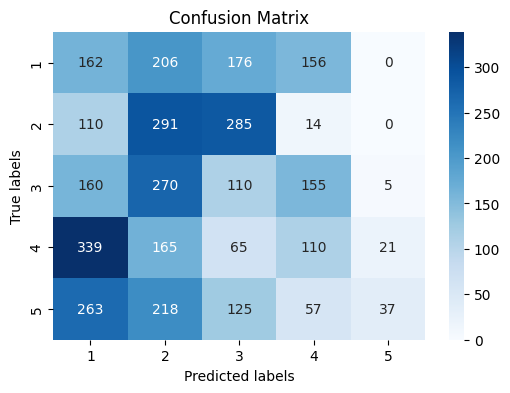

/tmp/ipykernel_3598/2298293002.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(h1), inf)


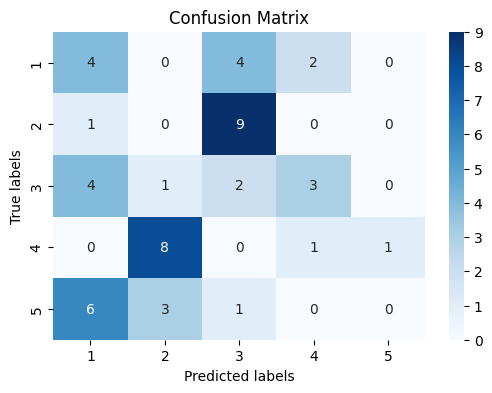

(20.285714285714285, 14.0)

In [90]:
train_acc = test_model(model, batched_train)
test_acc = test_model(model, test_ds)
train_acc, test_acc

In [83]:
train_output[:3], train_labels[:3], test_output[:3], test_labels[:3]

(array([[-12.25951765, -11.73739356, -12.16465818, -12.43255179,
         -12.21841941],
        [ -3.33184295,  -3.85443406,  -3.59372751,  -3.49040701,
          -4.06762648],
        [ -5.66495609,  -5.27874103,  -5.0860943 ,  -5.99497062,
          -5.27889644]]),
 array([0, 0, 0]),
 array([[-4.65562942, -5.18804091, -4.89775629, -4.81371463, -4.9579128 ],
        [-3.96060163, -4.36754409, -3.94791209, -3.98437224, -4.57090509],
        [-3.93864128, -4.87370556, -4.3964019 , -4.0967265 , -4.61004798]]),
 array([0, 0, 0]))

---
> check the correct train classification

In [74]:
train_pred_classes = np.argmax(train_output, axis=1)
train_correct_pred = train_pred_classes == train_labels

# Number of correct predictions
train_correct_indices = np.where(train_correct_pred)[0]
num_train_correct_pred = np.sum(train_correct_pred)
print(f"{num_train_correct_pred = }")

num_train_correct_pred = 609


In [75]:
test_pred_classes = np.argmax(test_output, axis=1)
test_correct_pred = test_pred_classes == test_labels

# Number of correct predictions
test_correct_indices = np.where(test_correct_pred)[0]
num_test_correct_pred = np.sum(test_correct_pred)
print(f"{num_test_correct_pred = }")

num_test_correct_pred = 10
